In [1]:
# install machine gnostic learning packages
# ! pip install machinegnostics # only if not installed

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Robust regression and mlflow integration

2025/05/27 13:58:03 INFO mlflow.tracking.fluent: Experiment with name 'GnosticRobustRegressorExperiment' does not exist. Creating a new experiment.
2025/05/27 13:58:03 INFO mlflow.pyfunc: Validating input example against model signature


Iteration: 1 - Machine Gnostic loss - hi : 79.2321, rentropy: 0.0666
Iteration: 2 - Machine Gnostic loss - hi : 78.6316, rentropy: 0.015
Iteration: 3 - Machine Gnostic loss - hi : 78.7103, rentropy: 0.0137
Iteration: 4 - Machine Gnostic loss - hi : 78.2884, rentropy: 0.0133
Convergence reached at iteration 4 with loss/rentropy change below tolerance.


2025/05/27 13:58:05 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'machinegnostics'}
Successfully registered model 'GnosticRobustRegressor'.
Created version '1' of model 'GnosticRobustRegressor'.


Predictions:
 [0.54419048 0.55752326 0.53273363 0.55583442 0.481541   0.4369952
 0.58809396 0.52532075 0.56273308 0.51617675]


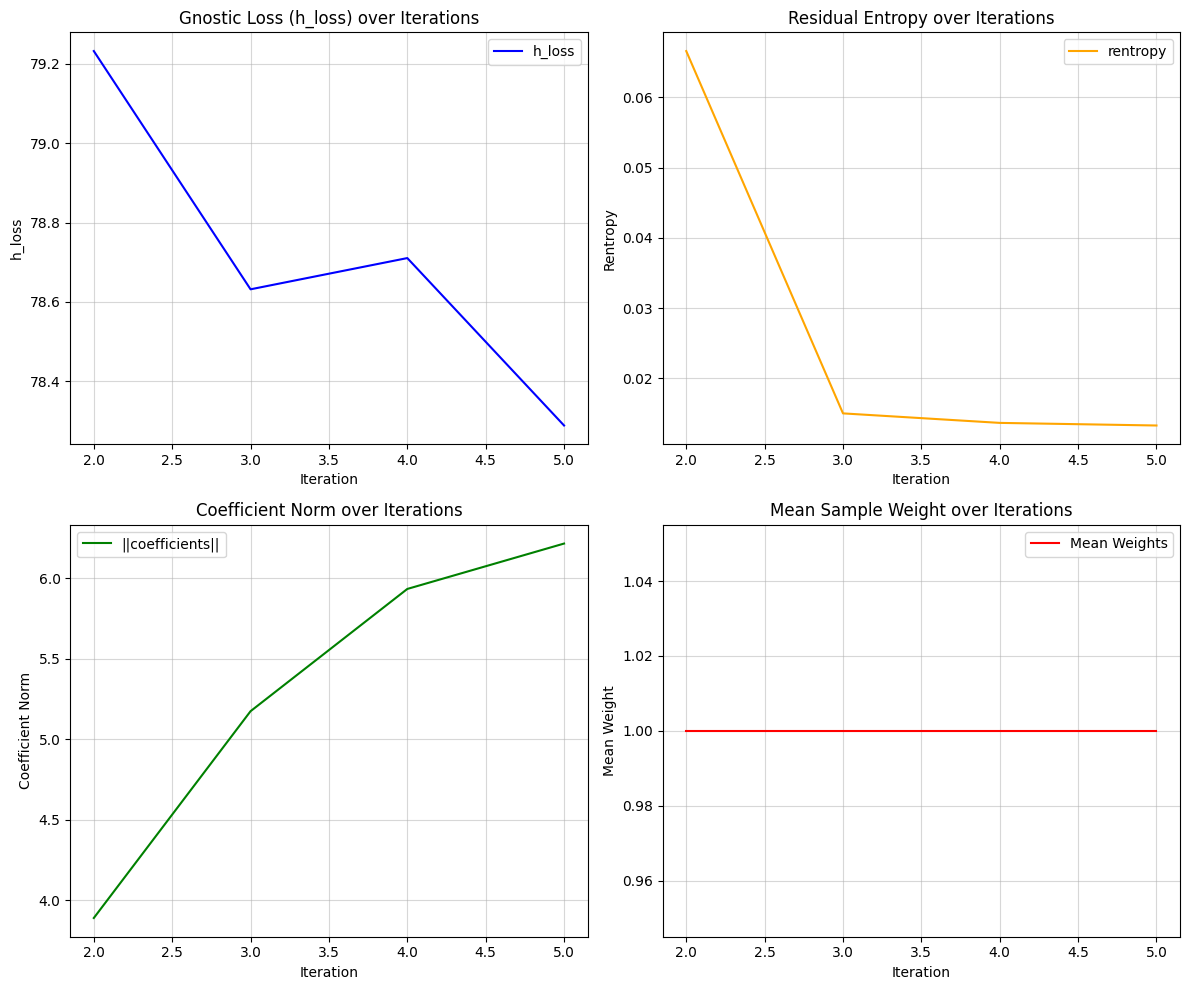

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import mlflow
import os
import mlflow.pyfunc
from mlflow.models.signature import infer_signature
from machinegnostics.models import RobustRegressor
from machinegnostics.metrics import hc, robr2, root_mean_squared_error
import matplotlib.pyplot as plt

# --- Train RobustRegressor ---
X = np.random.rand(100, 2)
y = np.random.rand(100)
model = RobustRegressor(degree=3, mg_loss='hi', verbose=True)
model.fit(X, y)

# --- MLflow Logging ---
input_example = pd.DataFrame(X, columns=["feature1", "feature2"])
signature = infer_signature(input_example, model.predict(input_example))

y_pred = model.predict(X)
hc_score = hc(y, y_pred)
rob_r2_score = robr2(y, y_pred)
rmse_score = root_mean_squared_error(y, y_pred)

# set experiment name
mlflow.set_experiment("GnosticRobustRegressorExperiment")
# ensure the experiment exists
experiment = mlflow.get_experiment_by_name("GnosticRobustRegressorExperiment")
if experiment is None:
    mlflow.create_experiment("GnosticRobustRegressorExperiment")

with mlflow.start_run():
    mlflow.pyfunc.log_model(
        artifact_path="robust_regressor",
        python_model=model,
        registered_model_name="GnosticRobustRegressor",
        input_example=input_example,
        signature=signature
    )
    mlflow.log_metric("hc", hc_score)
    mlflow.log_metric("rob_r2", rob_r2_score)
    mlflow.log_metric("rmse", rmse_score)


## prediction with mlflow

In [ ]:
# for more details check the MLflow UI
# mlflow ui --port 5000

In [5]:
# --- Load model from MLflow and predict ---
loaded_model = mlflow.pyfunc.load_model("models:/GnosticRobustRegressor/1")
X_test = pd.DataFrame(np.random.rand(10, 2), columns=["feature1", "feature2"])
predictions = loaded_model.predict(X_test)
print("Predictions:\n", predictions)

Predictions:
 [0.6184933  0.43930425 0.53477545 0.54155667 0.45222774 0.60004447
 0.46342895 0.44571986 0.60154125 0.56160366]


## History of params

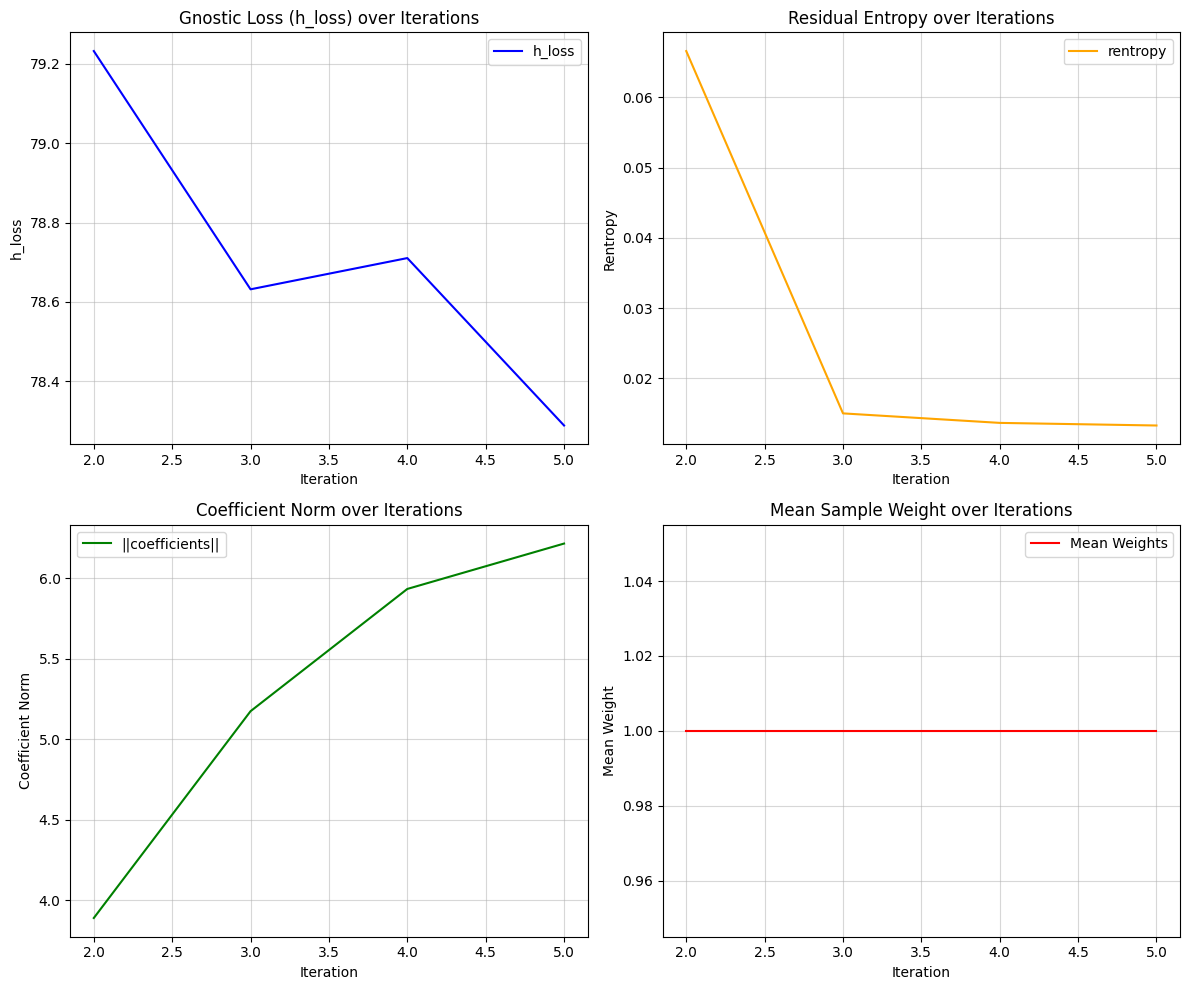

In [6]:
# --- Plot model history ---
if isinstance(model._history, list):
    history_df = pd.DataFrame(model._history)
else:
    history_df = pd.DataFrame([model._history])

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
plot_idx = 0

if 'h_loss' in history_df.columns and history_df['h_loss'].notnull().any():
    axes[plot_idx].plot(history_df['iteration'], history_df['h_loss'], label='h_loss', color='blue')
    axes[plot_idx].set_xlabel('Iteration')
    axes[plot_idx].set_ylabel('h_loss')
    axes[plot_idx].set_title('Gnostic Loss (h_loss) over Iterations')
    axes[plot_idx].legend()
    axes[plot_idx].grid(True, alpha=0.5)
    plot_idx += 1

if 'rentropy' in history_df.columns and history_df['rentropy'].notnull().any():
    axes[plot_idx].plot(history_df['iteration'], history_df['rentropy'], label='rentropy', color='orange')
    axes[plot_idx].set_xlabel('Iteration')
    axes[plot_idx].set_ylabel('Rentropy')
    axes[plot_idx].set_title('Residual Entropy over Iterations')
    axes[plot_idx].legend()
    axes[plot_idx].grid(True, alpha=0.5)
    plot_idx += 1

if 'coefficients' in history_df.columns and history_df['coefficients'].notnull().any():
    coef_norms = history_df['coefficients'].apply(lambda x: np.linalg.norm(x) if x is not None else np.nan)
    axes[plot_idx].plot(history_df['iteration'], coef_norms, label='||coefficients||', color='green')
    axes[plot_idx].set_xlabel('Iteration')
    axes[plot_idx].set_ylabel('Coefficient Norm')
    axes[plot_idx].set_title('Coefficient Norm over Iterations')
    axes[plot_idx].legend()
    axes[plot_idx].grid(True, alpha=0.5)
    plot_idx += 1

if 'weights' in history_df.columns and history_df['weights'].notnull().any():
    mean_weights = history_df['weights'].apply(lambda x: np.mean(x) if x is not None else np.nan)
    axes[plot_idx].plot(history_df['iteration'], mean_weights, label='Mean Weights', color='red')
    axes[plot_idx].set_xlabel('Iteration')
    axes[plot_idx].set_ylabel('Mean Weight')
    axes[plot_idx].set_title('Mean Sample Weight over Iterations')
    axes[plot_idx].legend()
    axes[plot_idx].grid(True, alpha=0.5)
    plot_idx += 1

for i in range(plot_idx, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()